In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from albumentations import HorizontalFlip, VerticalFlip, Compose, RandomBrightnessContrast,ShiftScaleRotate, GaussNoise
import os

from tensorflow import keras
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import random
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.mixed_precision import set_global_policy
from sklearn.metrics import jaccard_score
def crop_image(image, crop_size=256):
    if isinstance(image, str):  # If the image is a file path
        img = Image.open(image)
    elif isinstance(image, np.ndarray):  # If the image is a numpy array
        img = Image.fromarray(image)

    width, height = img.size

    crops = []
    for i in range(0, height, crop_size):
        for j in range(0, width, crop_size):
            box = (j, i, j + crop_size, i + crop_size)
            crop = img.crop(box)
            crops.append(np.array(crop))

    return crops


def rle_to_mask(rle_list, shape=(768, 768)):
    # Convert the run-length encoding to a binary mask
    mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    for rle in rle_list:
        if pd.isnull(rle):  # If the RLE is NaN, skip this loop iteration
            continue
        starts, lengths = map(np.asarray, (rle.split()[0:][::2], rle.split()[1:][::2]))
        starts = starts.astype(int) - 1
        lengths = lengths.astype(int)  # Convert lengths to int
        ends = starts + lengths
        for start, end in zip(starts, ends):
            mask[start:end] = 1

    return mask.reshape(shape).T  # Reshape the mask
# Load the CSV file into a DataFrame
df = pd.read_csv('/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv')

# Group the DataFrame by 'ImageId' to get a list of masks for each image
grouped = df.groupby('ImageId')['EncodedPixels'].apply(list)

random.seed(42)  # for reproducibility
sample_size = int(len(grouped) * 0.02)
sampled_filenames = random.sample(list(grouped.keys()), sample_size)

# Initialize empty lists to store the image patches and labels
patch_images = []
masks = []
labels = []

# Loop over the grouped DataFrame
for filename in sampled_filenames:
    image_path = '/kaggle/input/airbus-ship-detection/train_v2/' + filename
    rle_list = grouped[filename]
    # Crop the image into patches
    img = Image.open(image_path)
    # Convert the run-length encoding to a binary mask
    mask = rle_to_mask(rle_list)
    # Loop over the image and mask patches
    patch_images.append(img)
    masks.append(mask)
    label = 1 if np.any(mask) else 0
    labels.append(label)

# Convert the lists into numpy arrays for future use
patch_images = np.array(patch_images)
labels = np.array(labels)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Visualize some images

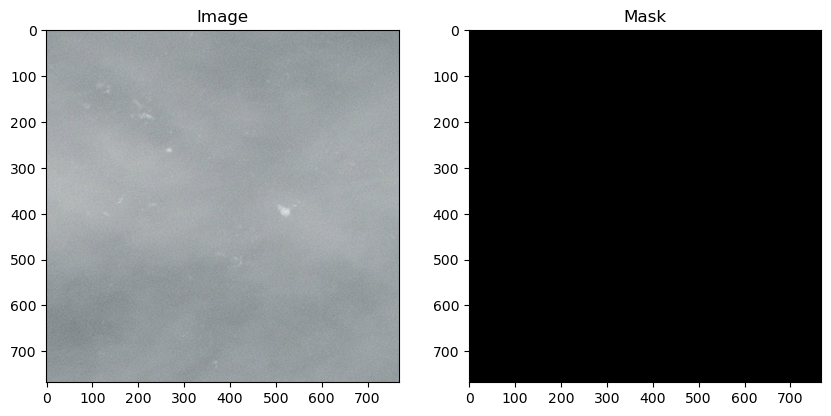

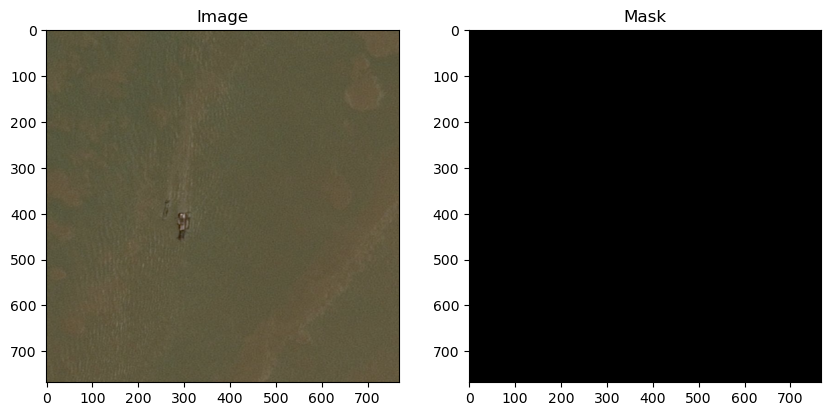

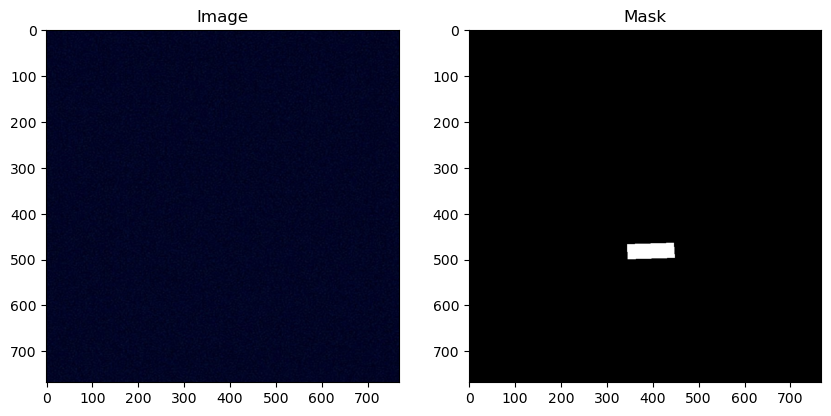

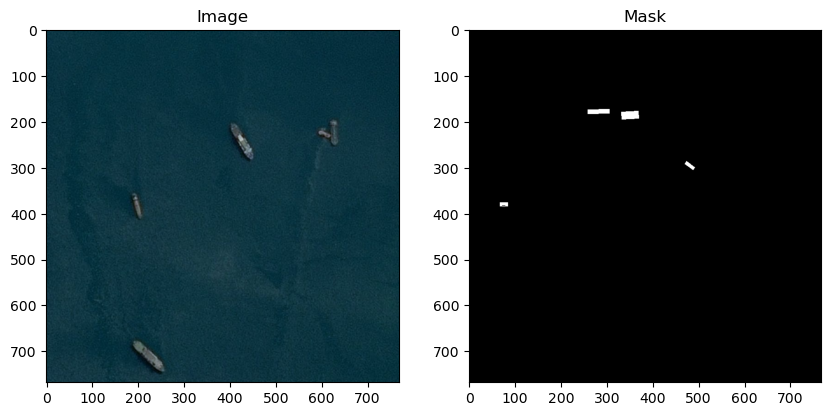

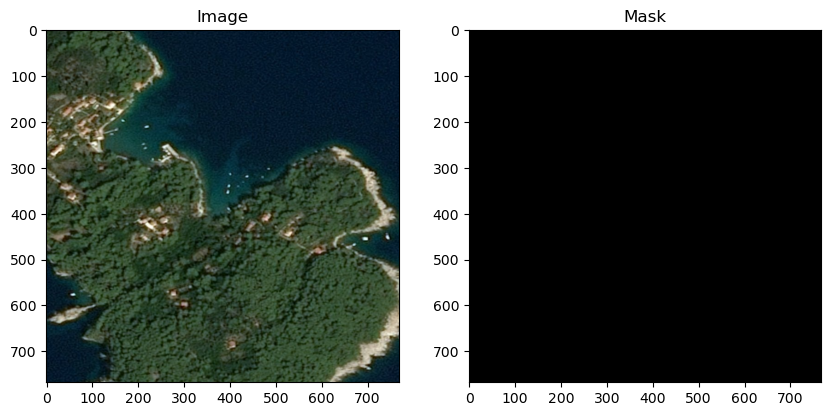

In [2]:
def show_image_and_mask(image, mask):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title('Image')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.show()

for i in range(5):
    show_image_and_mask(patch_images[i], rle_to_mask(grouped[i]))


# Check whether all images are in 768 by 768

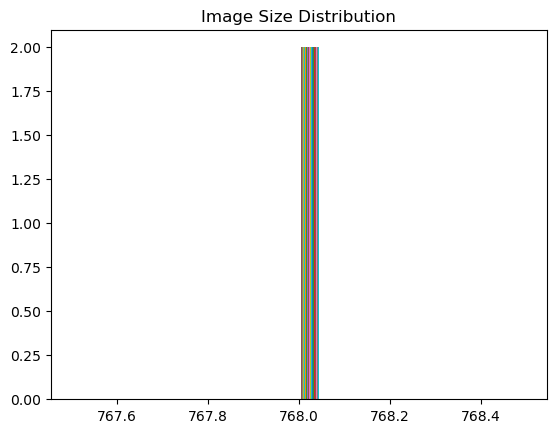

In [4]:
image_sizes = [img.size for img in patch_images]
plt.hist(image_sizes, bins=20)
plt.title('Image Size Distribution')
plt.show()


# Distribution of images with ships and without

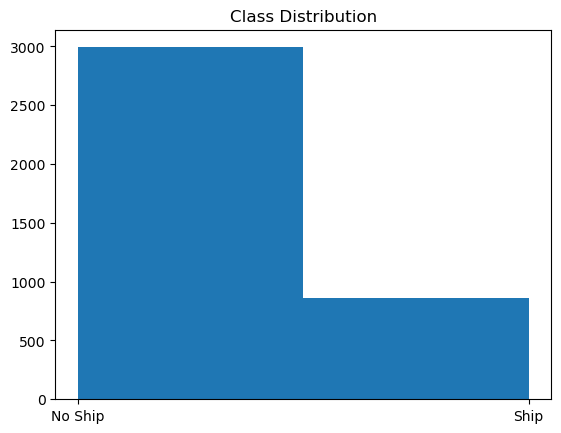

In [3]:
plt.hist(labels, bins=2)
plt.title('Class Distribution')
plt.xticks([0, 1], ['No Ship', 'Ship'])
plt.show()


# Lets look on the size of mask at most

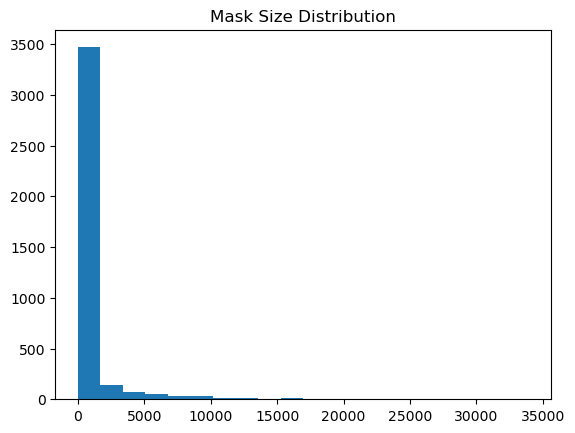

In [4]:
mask_sizes = [np.count_nonzero(mask) for mask in masks]

plt.hist(mask_sizes, bins=20)
plt.title('Mask Size Distribution')
plt.show()


# Analyse the distribution of color

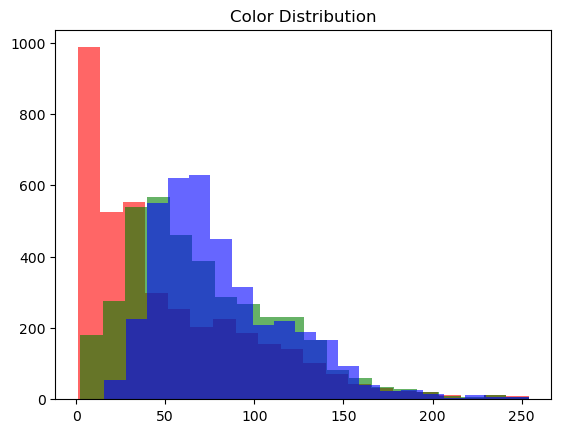

In [10]:
r_values = [np.mean(np.array(img)[:,:,0]) for img in patch_images]
g_values = [np.mean(np.array(img)[:,:,1]) for img in patch_images]
b_values = [np.mean(np.array(img)[:,:,2]) for img in patch_images]

plt.hist(r_values, bins=20, color='red', alpha=0.6)
plt.hist(g_values, bins=20, color='green', alpha=0.6)
plt.hist(b_values, bins=20, color='blue', alpha=0.6)
plt.title('Color Distribution')
plt.show()


# Analyse the number of ships per image

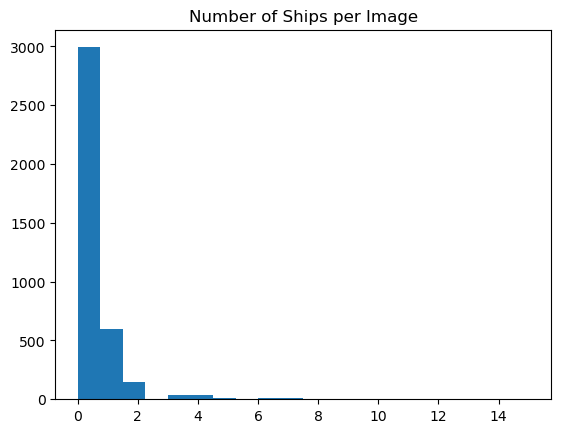

In [11]:
from scipy.ndimage import label

number_of_ships = [label(mask)[1] for mask in masks]
plt.hist(number_of_ships, bins=20)
plt.title('Number of Ships per Image')
plt.show()
